In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
548,PRV51690,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
25404,BENE104230,CLM46790,2009-04-13,2009-04-17,PRV52063,9000,PHY383538,PHY354213,NaN,2009-04-13,7140,1068.0,2009-04-17,476,71531,2724,78607,4019,NaN,NaN,NaN,NaN,NaN,NaN,8181.0,NaN,NaN,NaN,NaN,NaN


In [6]:
inpatient['Provider'].nunique()

2092

In [7]:
print(f'outpatient nunique provider: {outpatient["Provider"].nunique()}')
outpatient.sample()

outpatient nunique provider: 5012


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
420415,BENE131292,CLM623372,2009-10-10,2009-10-10,PRV51459,60,PHY423534,NaN,PHY338032,78071,7812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [8]:
df = inpatient.groupby('Provider').agg(
    IPCountClaimID = ('ClaimID', 'count')
)
df

,IPCountClaimID
Provider,
PRV51001,5
PRV51003,62
PRV51007,3
PRV51008,2
PRV51011,1
...,...
PRV57719,4
PRV57728,1
PRV57729,11


In [9]:
outpatient['Provider'].nunique()

5012

In [10]:
out_df = outpatient.groupby('Provider').agg(
    OPCountClaimID = ('ClaimID', 'count')
)
out_df

,OPCountClaimID
Provider,
PRV51001,20
PRV51003,70
PRV51004,149
PRV51005,1165
PRV51007,69
...,...
PRV57759,28
PRV57760,22
PRV57761,82


In [11]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left: Provider, IPCountClaimID
    out_df,  # Right: Provider, OPCountClaimID
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [12]:
provider_claims

,IPCountClaimID,OPCountClaimID
Provider,,
PRV51001,5.0,20.0
PRV51003,62.0,70.0
PRV51004,0.0,149.0
PRV51005,0.0,1165.0
PRV51007,3.0,69.0
...,...,...
PRV57759,0.0,28.0
PRV57760,0.0,22.0
PRV57761,0.0,82.0


In [13]:
provider_claims['IPCountClaimID'].sum()

np.float64(40474.0)

In [14]:
provider_claims['OPCountClaimID'].sum()


np.float64(517737.0)

In [15]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)
final_df

,Provider,IPCountClaimID,OPCountClaimID,PotentialFraud
0,PRV51001,5.0,20.0,No
1,PRV51003,62.0,70.0,Yes
2,PRV51004,0.0,149.0,No
3,PRV51005,0.0,1165.0,Yes
4,PRV51007,3.0,69.0,No
...,...,...,...,...
5405,PRV57759,0.0,28.0,No
5406,PRV57760,0.0,22.0,No
5407,PRV57761,0.0,82.0,No
5408,PRV57762,0.0,1.0,No


In [16]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPCountClaimID,OPCountClaimID,PotentialFraud
0,PRV51001,5.0,20.0,0
1,PRV51003,62.0,70.0,1
2,PRV51004,0.0,149.0,0
3,PRV51005,0.0,1165.0,1
4,PRV51007,3.0,69.0,0
...,...,...,...,...
5405,PRV57759,0.0,28.0,0
5406,PRV57760,0.0,22.0,0
5407,PRV57761,0.0,82.0,0
5408,PRV57762,0.0,1.0,0


In [17]:
# # Create a csv file with the selected features for later. Only once.
# final_df.to_csv('ClaimID_count.csv', index=False)

In [18]:
# feature total amount reimbursed by by the insurance per provider:
X = final_df[['IPCountClaimID', 'OPCountClaimID']]
X


,IPCountClaimID,OPCountClaimID
0,5.0,20.0
1,62.0,70.0
2,0.0,149.0
3,0.0,1165.0
4,3.0,69.0
...,...,...
5405,0.0,28.0
5406,0.0,22.0
5407,0.0,82.0
5408,0.0,1.0


In [19]:
# target value (True or False), when 1 == Yes, and 0 == No.
y = final_df['PotentialFraud']
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [20]:
# 1. Split the data: 80% for training, 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [21]:
# 2. Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# 3. Fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
# 4. Make prediction on the test 
y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


In [24]:
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

Confusion Matrix:
[[966  11]
 [ 65  40]]


In [25]:
from sklearn.metrics import  precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precicion = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print(f'Accuracy: {accuracy:.2}')
print(f'precision: {precicion:.2}')
print(f'recall: {recall:.2}')
print(f'f1 score: {f1:.2}')

Accuracy: 0.93
precision: 0.78
recall: 0.38
f1 score: 0.51


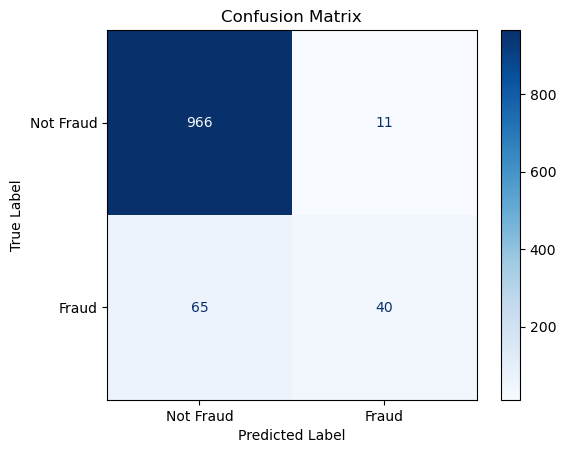

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

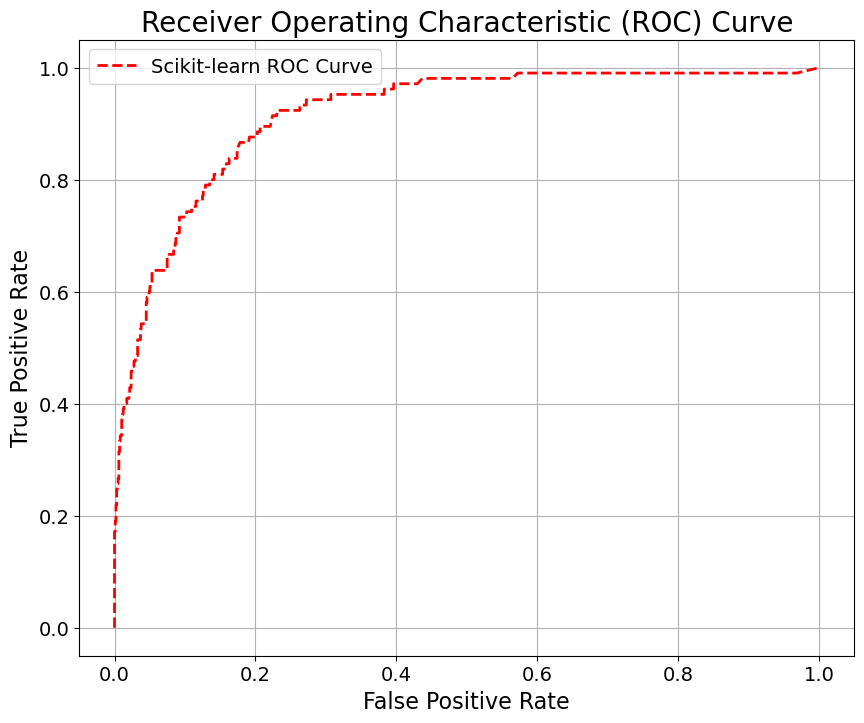

In [27]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [28]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9165033874348102)

### loooking for a better threshold to find better f1 score:

In [72]:
# # Get predicted probabilities
# y_proba = model.predict_proba(X_test)[:, 1]

In [73]:
# precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
# best_threshold = thresholds[f1_scores.argmax()]
# print(f"Optimal threshold based on F1-score: {best_threshold}")

In [74]:
# # apply the new best threshold to the predicted probabilities
# y_pred_custom = (y_proba >= best_threshold).astype(int)
# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred_custom)
# print("Confusion Matrix:\n", cm)

In [75]:
# # flatten the confusion matrix and break it down into four components.
# TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix after manipulating by adjusting the threshold:\n')
# # Calculating metrics
# accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
# print(f'Accuracy: {accuracy:.2f}')
# precision = TP / (TP + FP) if (TP + FP) != 0 else 0
# print(f'Precision: {precision:.2f}')
# recall = TP / (TP + FN) if (TP + FN) != 0 else 0
# print(f'Recall: {recall:.2f}')
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# print(f'F1 Score: {f1_score:.2f}')

# Apply cross validation

In [30]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.93567384 0.93916593 0.91521079 0.93155095 0.92768607]
Mean auc_roc: 0.9299


## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [32]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9343


In [33]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.83      0.28      0.41       105

    accuracy                           0.92      1082
   macro avg       0.88      0.64      0.69      1082
weighted avg       0.92      0.92      0.91      1082



In [34]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[971   6]
 [ 76  29]]


# <center>SMOTE

In [35]:
# Checks how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPCountClaimID,OPCountClaimID,PotentialFraud
0,PRV51001,5.0,20.0,0
1,PRV51003,62.0,70.0,1
2,PRV51004,0.0,149.0,0
3,PRV51005,0.0,1165.0,1
4,PRV51007,3.0,69.0,0


In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [38]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [39]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [40]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[882  99]
 [ 18  83]]


In [41]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.89
Precision: 0.46
Recall: 0.82
F1 Score: 0.59


### <center>SMOTE AUC_ROC score:

In [42]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9506


# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [43]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


In [44]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9512


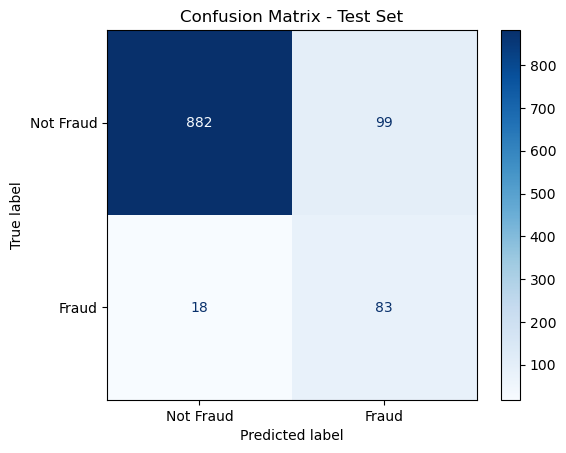

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [46]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[882  99]
 [ 18  83]]


In [47]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.89
Precision: 0.46
Recall: 0.82
F1 Score: 0.59
